#<A>**IMPLEMENTATION LAB_5**

>**CONTENT**
*  `INTRODUCTION`
* `Required libraries`
* `LOAD DATA`
* `SELECT ONE RANDOMLY SAMPLED WAV FILE`
* `PRINT THE SHAPE OF WAV FILE`
* `PRINT THE SAMPLE RATE`
* `VISUALIZE THE WAVWE FORM`
* `SPECTROGRAM REPRESENTATION`
* `SPECTOGRAM BY LIBROSA`
* `MFCC REPRESENTATION`
* `TRANSCRIPT FOR AUDIO`
* `TRANSCRIPTS FOR EACH WAVEFORM`
* `PRE-PROCESSING`

## <a>**INTRODUCTION**


 >**Deep learning based end-to-end speech recognition**
*  `The goal of this assignment is to get familiar with applications that require speech data as input.`

>**DEFINATION**
* `Speech Recognition is a supervised learning task. In the speech recognition problem input will be the audio signal and we have to predict the text from the audio signal. We can’t take the raw audio signal as input to our model because there will be a lot of noise in the audio signal. It is observed that extracting features from the audio signal and using it as input to the base model will produce much better performance than directly considering raw audio signal as input.`

>**NOTES**
* `For handling the audio data, we are going to use an extremely useful utility called torchaudio which is a library built by the PyTorch team specifically for audio data.`




## <a>**Required libraries**

In [ ]:
#install required libraries 
!pip install torchaudio==0.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import libraries
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

import torch
import torchaudio

import wave
import sys

In [ ]:
# print version
print(torch.__version__)
print(torchaudio.__version__)

1.11.0+cu113
0.11.0+cu113


##**Task 1:**


### **Basic data exploration**

>`Select one randomly sampled wav file in the given folder, perform the following analysis:`
* `1) Print the shape of the picked waveform`
* `2) Print the sample rate of the waveform.` 
* `3) Visualize the waveform using matplotlib`
* `4) Create the spectrogram representation of the picked waveform and visualize it.` 
* `5) Create the MFCC representation of the picked waveform and visualize it.`

`Reference:` https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration/notebook 

### <a>**LOAD DATA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### <A>**SELECT ONE RANDOMLY SAMPLED WAV FILE** 

In [ ]:
# Select one randomly sampled wav file in the given folder, perform the following analysis
sample_wav= "/content/drive/MyDrive/speechdata/wavs/LJ001-0012.wav"
waveform, sample_rate = torchaudio.load(sample_wav)

### <A>**PRINT THE SHAPE OF WAV FILE**

In [ ]:
# Print the shape of the picked waveform
print("Shape of waveform: {}".format(waveform.size()))

Shape of waveform: torch.Size([1, 181661])


### <A>**PRINT THE SAMPLE RATE**

In [ ]:
# Print the sample rate of the waveform.
print("Sample rate of waveform: {}".format(sample_rate))

Sample rate of waveform: 22050


### <A>**VISUALIZE THE WAVWE FORM**

>To open our WAV file, we use the WAVE module in Python

In [ ]:
# Visualize the waveform using matplotlib
import wave
wav_obj = wave.open('/content/drive/MyDrive/speechdata/wavs/LJ001-0012.wav', 'rb')#ANOTHER WAY TO READ WAVEFORM DATA FILE

>A sound wave is a continuous quantity that needs to be sampled at some time interval to digitize it. The sampling rate quantifies how many samples of the sound are taken every second. We can access this information using the following method

In [ ]:
sample_freq = wav_obj.getframerate()#ANOTHER WAY TO GET SAMPLE RATE
sample_freq

22050

>The sample frequency quantifies the number of samples per second. In this case, it is 22050 times per second

In [ ]:
n_samples = wav_obj.getnframes()#ANOTHER WAY TO GET SAMPLES
n_samples

181661

 >The number of individual frames, or samples IS 181661

In [ ]:
t_audio = n_samples/sample_freq
t_audio

8.23859410430839

>calculate how long our audio file is in seconds

In [ ]:
n_channels = wav_obj.getnchannels()
n_channels

1

>let us to check the number of channels

>let us to get the values of the signal, that is, the amplitude of the wave at that point in time

In [ ]:
signal_wave = wav_obj.readframes(n_samples)
# signal_wave 

In [ ]:
signal_array = np.frombuffer(signal_wave, dtype=np.int16)
signal_array.shape

(181661,)

>calculate the time at which each sample is taken.

In [ ]:
times = np.linspace(0, n_samples/sample_freq, num=n_samples)
times

array([0.00000000e+00, 4.53517236e-05, 9.07034471e-05, ...,
       8.23850340e+00, 8.23854875e+00, 8.23859410e+00])

>This is simply the total length of the track in seconds, divided by the number of samples. We can use linspace() from numpy to create an array of timestamps

In [ ]:
times.shape

(181661,)

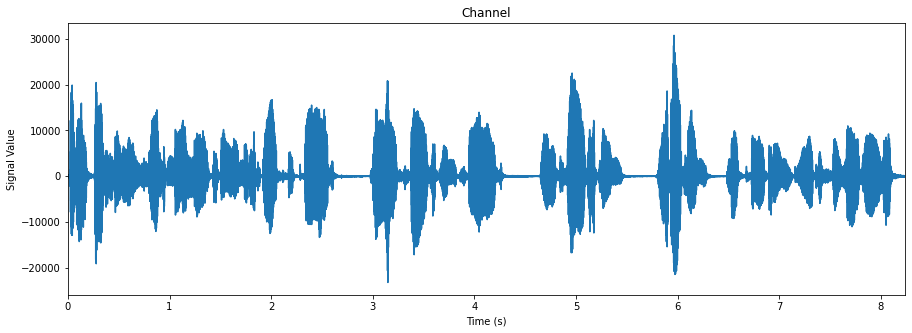

In [ ]:
# Plotting the Signal Amplitude
plt.figure(figsize=(15, 5))
plt.plot(times,signal_array)
plt.title('Channel')
plt.ylabel('Signal Value')
plt.xlabel('Time (s)')
plt.xlim(0, t_audio)
plt.show()

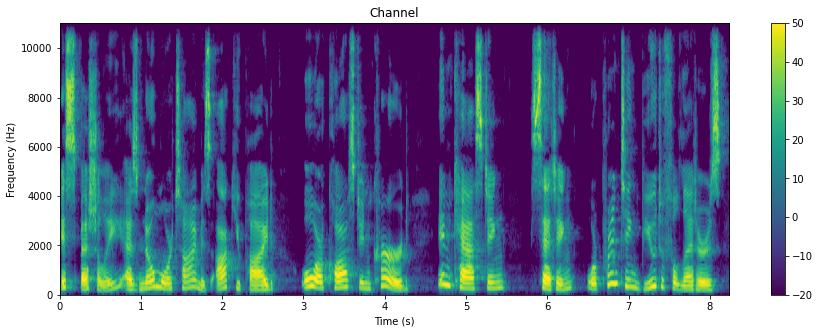

In [ ]:
#Plotting the Frequency Spectrum
plt.figure(figsize=(15, 5))
plt.specgram(signal_array, Fs=sample_freq, vmin=-20, vmax=50)
plt.title('Channel')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.xlim(0, t_audio)
plt.colorbar()
plt.show()

### <A>**SPECTROGRAM REPRESENTATION**

>A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. 

In [ ]:
#  Create and Visualize the Spectrogram
train_audio_path = '/content/drive/MyDrive/speechdata/'
filename = '/wavs/LJ001-0012.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

In [ ]:
# Define a function that calculates spectrogram.
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [ ]:
samples[0:22050].shape

(22050,)

Text(0.5, 0, 'Seconds')

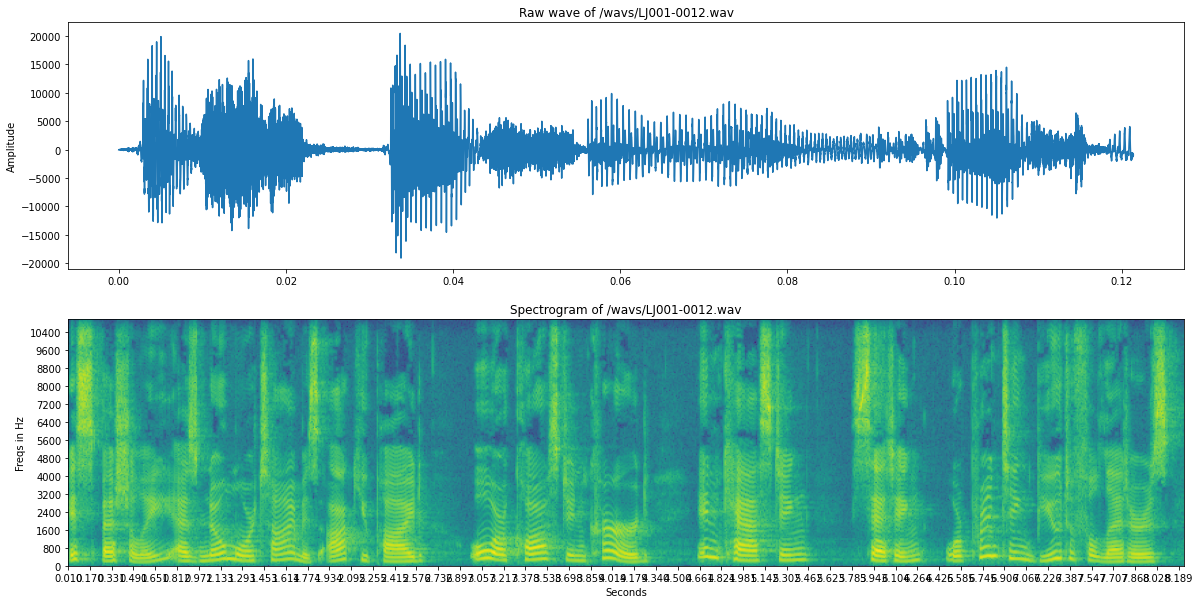

In [ ]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples[0:22050])

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

### <A>**SPECTOGRAM BY LIBROSA**

In [ ]:
samples, sample_rate = librosa.load('/content/drive/MyDrive/speechdata/wavs/LJ001-0012.wav')

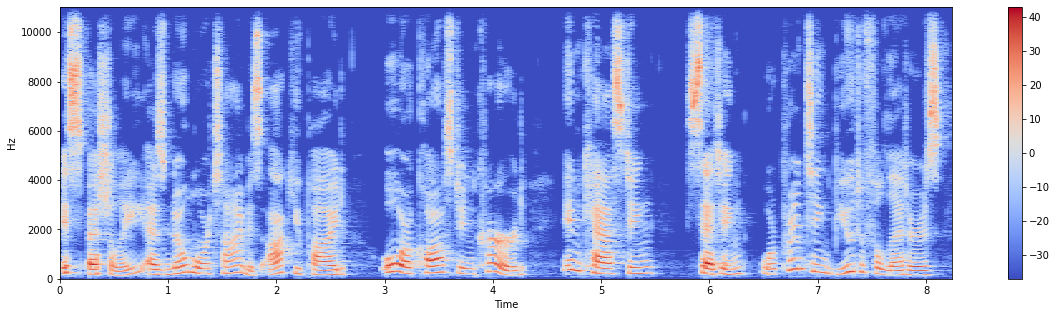

In [ ]:
#SPECTOGRAM BY LIBROSA
X = librosa.stft(samples)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(20, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()

### <A>**MFCC REPRESENTATION**

>MFCC is the widely used technique for extracting the features from the audio signal.

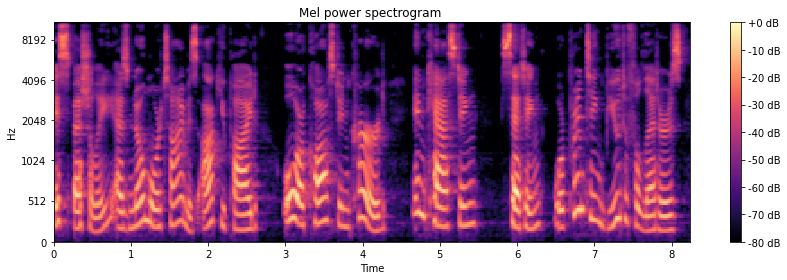

In [ ]:
# Create the MFCC representation of the picked waveform and visualize it.
# From this tutorial
# https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

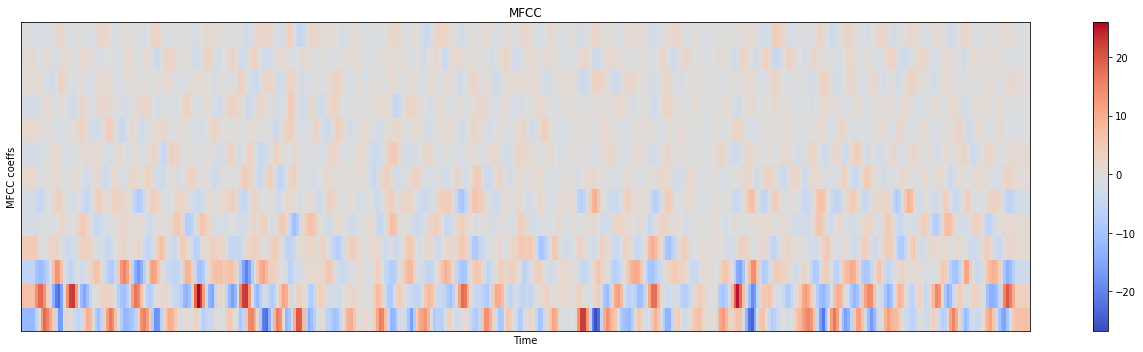

In [ ]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(18, 5))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [ ]:
ipd.Audio(samples, rate=sample_rate)#DISPLAY SAMPLE AUDIO

## **Task 2:**


### <A>**TRANSCRIPT FOR AUDIO**

`Creating a Wav2Vec2 model that can perform feature extraction and 
classification.`

In [ ]:
# TODO code for task 2
# Wav2vec2 https://towardsdatascience.com/wav2vec-2-0-a-framework-for-self-supervised-learning-of-speech-representations-7d3728688cae 
# CTC Algorithm https://distill.pub/2017/ctc/
# Get the Transcript for the random selected file

In [ ]:
# Installing Transformer
!pip install -q transformers

     |████████████████████████████████| 4.2 MB 8.4 MB/s 
     |████████████████████████████████| 6.6 MB 47.3 MB/s 
     |████████████████████████████████| 596 kB 12.2 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 


In [ ]:
# Import necessary library

# For managing audio file
import librosa

#Importing Pytorch
import torch

#Importing Wav2Vec
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer

>`Wav2Vec2 is a speech model that accepts a float array corresponding to the raw 
waveform of the speech signal. Wav2Vec2 model was trained using connectionist temporal classification (CTC) so the model output has to be decoded using Wav2Vec2Tokenizer `

In [ ]:
# Reading taken audio clip
import IPython.display as display
display.Audio("/content/drive/MyDrive/speechdata/wavs/LJ001-0012.wav", autoplay=False)

>`note the Wav2Vec model is pre-trained on 16 kHz frequency, so we make sure our raw audio file is also resampled to a 16 kHz sampling rate. I have used online audio tool conversion to resample the ‘taken’ audio clip into 16kHz.`

`Loading the audio file using the librosa library and mentioning my audio clip size is 16000 Hz. It converts the audio clip into an array and is stored into the ‘audio’ variable.`

In [ ]:
# Loading the audio file
audio, rate = librosa.load("/content/drive/MyDrive/speechdata/wavs/LJ001-0012.wav", sr = 16000)

In [ ]:
# printing audio 
print(audio)

[-0.00109078 -0.00166876 -0.00125507 ... -0.00229651 -0.00028658
  0.        ]


In [ ]:
# printing rate
print(rate)

16000


In [ ]:
# Importing Wav2Vec pretrained model

tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:752: FutureWarning:

The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.



Downloading:   0%|          | 0.00/360M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Taking an input value

input_values = tokenizer(audio, return_tensors = "pt").input_values

In [ ]:
# Storing logits (non-normalized prediction values)
logits = model(input_values).logits

In [ ]:
# Storing predicted ids
prediction = torch.argmax(logits, dim = -1)

In [ ]:
# Passing the prediction to the tokenzer decode to get the transcription
transcription = tokenizer.batch_decode(prediction)[0]

In [ ]:
# Printing the transcription
print(transcription)

ESPECIALLY AS NO MORE TIME IS OCCUPIED OR COST INCURRED INCASTING SETTING OR PRINTING BEAUTIFUL LETTERS


## **Task 3:**

### <A>**TRANSCRIPTS FOR EACH WAVEFORM**

`Extract acoustic features and generate predicted transcript for each waveform in the given dataset`

In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [ ]:
torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(torchaudio.__version__)
print(device)

1.11.0+cu113
0.11.0+cu113
cpu


In [ ]:
model = bundle.get_model().to(device)

print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [ ]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [ ]:
# TODO code for task 3
import IPython
def audio_text(SPEECH_FILE):

  waveform, sample_rate = torchaudio.load(SPEECH_FILE)
  waveform = waveform.to(device)

  if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

  with torch.inference_mode():
    emission, _ = model(waveform)

  decoder = GreedyCTCDecoder(labels=bundle.get_labels())
  transcript = decoder(emission[0])

  hypotheses= transcript.replace('|'," ")
  audio =IPython.display.Audio(SPEECH_FILE)
  return hypotheses 

In [ ]:
import os
files = os.listdir('/content/drive/MyDrive/wavs')
audio_url= np.sort(files)
len(audio_url)

100

In [ ]:
transcripts=[]
for audio in range(len(audio_url)):
  transcript = audio_text(os.path.join('/content/drive/MyDrive/speechdata/wavs',audio_url[audio] ))
  transcripts.append(transcript)

In [ ]:
# print the hypotheses
transcripts

['PRINTING IN THE ONLY SENSE WITH WHICH WE ARE AT PRESENT CONCERNED DIFFERS FROM MOST IF NOT FROM ALL THE ARTS AND CRAFTS REPRESENTED IN THE EXHIBITION ',
 'IN BEING COMPARATIVELY MODERN ',
 'FOR ALTHOUGH THE CHINESE TOOK IMPRESSIONS FROM WOOD BLOCKS ENGRAVED IN RELIEF FOR CENTURIES BEFORE THE WOOD CUTTERS OF THE NETHERLANDS BY A SIMILAR PROCESS ',
 'PRODUCED THE BLOCK BOOKS WHICH WERE THE IMMEDIATE PREDECESSORS OF THE TRUE PRINTED BOOK ',
 'THE INVENTION OF MOVABLE METAL LETTERS IN THE MIDDLE OF THE FIFTEENTH CENTURY MAY JUSTLY BE CONSIDERED AS THE INVENTION OF THE ART OF PRINTING ',
 'AND IT IS WORTH MENTION IN PASSING THAT AS AN EXAMPLE OF FINE TYPOGRAPHY ',
 'THE EARLIEST BOOK PRINTED WITH MOVABLE TYPES THE GUTTENBERG OR FORTY TWO LINE BIBLE OF ABOUT FOURTEEN FIFTY FIVE ',
 'HAS NEVER BEEN SURPASSED ',
 'PRINTING THEN FOR OUR PURPOSE MAY BE CONSIDERED AS THE ART OF MAKING BOOKS BY MEANS OF MOVABLE TYPES ',
 'NOW AS ALL BOOKS NOT PRIMARILY INTENDED AS PICTURE BOOKS CONSIST PRINCIPAL

## <a>**Task 4:**

>`evaluate the performance of the trained model on the testing dataset using Word Error Rate (WER), Match Error Rate (MER)
Hint: consider this package, https://pypi.org/project/jiwer/`

>JiWER: Similarity measures for automatic speech recognition evaluation

In [ ]:
!pip install jiwer

In [ ]:
import pandas as pd
labeled_data=pd.read_csv("/content/drive/MyDrive/speechdata/labels.csv",engine='python', error_bad_lines=False , header=None ,sep='|' )

In [ ]:
labeled_data.shape

(523, 3)

In [ ]:
Hypothesis_Truth= labeled_data.iloc[0:100,0:2]
Hypothesis_Truth

,0,1
0,LJ001-0001,"Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...
...,...,...
95,LJ001-0096,have now come into general use and are obvious...
96,LJ001-0097,a little reduced in ugliness. The design of th...
97,LJ001-0098,"and the whole effect is a little too gray, owi..."
98,LJ001-0099,"It must be remembered, however, that most mode..."


In [ ]:
Hypothesis_Truth.rename(columns = {0:'File_Name', 1:'Ground_Truth'}, inplace = True)

In [ ]:
Hypothesis_Truth['Hypothesis']= transcripts

In [ ]:
Hypothesis_Truth.head()

,File_Name,Ground_Truth,Hypothesis
0,LJ001-0001,"Printing, in the only sense with which we are ...",PRINTING IN THE ONLY SENSE WITH WHICH WE ARE A...
1,LJ001-0002,in being comparatively modern.,IN BEING COMPARATIVELY MODERN
2,LJ001-0003,For although the Chinese took impressions from...,FOR ALTHOUGH THE CHINESE TOOK IMPRESSIONS FROM...
3,LJ001-0004,"produced the block books, which were the immed...",PRODUCED THE BLOCK BOOKS WHICH WERE THE IMMEDI...
4,LJ001-0005,the invention of movable metal letters in the ...,THE INVENTION OF MOVABLE METAL LETTERS IN THE ...


###<A> **PRE-PROCESSING**

>It might be necessary to apply some pre-processing steps on either the hypothesis or ground truth text. This is possible with the transformation API

In [ ]:
import jiwer

ground_truth = list(Hypothesis_Truth['Ground_Truth'])
hypothesis = transcripts
# LowerCase, RemoveWhiteSpace, RemovePunctuation
transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemoveWhiteSpace(replace_by_space=True),
    jiwer.RemoveMultipleSpaces(),
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemovePunctuation(),
    jiwer.RemoveKaldiNonWords(),
    jiwer.ReduceToListOfListOfWords(word_delimiter=" ")
]) 

>Word error rate (WER) is a common metric of the performance of an automatic speech recognition (ASR) system.

In [ ]:
WER=[]
for i in range(len(Hypothesis_Truth)):
  wer= jiwer.wer(
      ground_truth[i], 
      hypothesis[i], 
      truth_transform=transformation, 
      hypothesis_transform=transformation
  )
  WER.append(wer)

>Match error rate is a metric of the performance of an automatic speech recognition system. This value indicates the percentage of words that were incorrectly predicted and inserted. The lower the value, the better the performance of the ASR system with a MatchErrorRate of 0 being a perfect score.

In [ ]:
MER=[]
for i in range(len(Hypothesis_Truth)):
  mer= jiwer.mer(
    ground_truth, 
    hypothesis, 
    truth_transform=transformation, 
    hypothesis_transform=transformation
  )
  MER.append(mer)

In [ ]:
Hypothesis_Truth['WER']= WER
Hypothesis_Truth['MER']= MER

In [ ]:
Hypothesis_Truth.head()#DATAFRAME

,File_Name,Ground_Truth,Hypothesis,WER,MER
0,LJ001-0001,"Printing, in the only sense with which we are ...",PRINTING IN THE ONLY SENSE WITH WHICH WE ARE A...,0.000000,0.070893
1,LJ001-0002,in being comparatively modern.,IN BEING COMPARATIVELY MODERN,0.000000,0.070893
2,LJ001-0003,For although the Chinese took impressions from...,FOR ALTHOUGH THE CHINESE TOOK IMPRESSIONS FROM...,0.083333,0.070893
3,LJ001-0004,"produced the block books, which were the immed...",PRODUCED THE BLOCK BOOKS WHICH WERE THE IMMEDI...,0.000000,0.070893
4,LJ001-0005,the invention of movable metal letters in the ...,THE INVENTION OF MOVABLE METAL LETTERS IN THE ...,0.000000,0.070893


## <a>**Task 5:**




---

`check files with the worst performance and perform a simple error analysis, e.g., what are the files having worser performance, and what are the potential reasons, do they share any common patterns?`

---


>The best achievable WER score is 0, which means that every word is transcribed correctly with no inserted words.

In [ ]:
# TODO code for task 5
Hypothesis_Truth.loc[Hypothesis_Truth['WER']>=0.25]

,File_Name,Ground_Truth,Hypothesis,WER,MER
6,LJ001-0007,"the earliest book printed with movable types, ...",THE EARLIEST BOOK PRINTED WITH MOVABLE TYPES T...,0.375000,0.070893
23,LJ001-0024,But the first Bible actually dated (which also...,BUT THE FIRST BIBLE ACTUALLY DATED WHICH ALSO ...,0.263158,0.070893
30,LJ001-0031,In 1465 Sweynheim and Pannartz began printing ...,IN FOURTEEN SIXTY FIVE SWAYNHEIM AND PANARCHS ...,0.357143,0.070893
37,LJ001-0038,while in 1470 at Paris Udalric Gering and his ...,WHILE IN FOURTEEN SEVENTY AT PARIS UDORICH GER...,0.272727,0.070893
44,LJ001-0045,"1469, 1470;",FOURTEEN SIXTY NINE FOURTEEN SEVENTY,2.500000,0.070893
54,LJ001-0055,"some of which -- as, e.g., that of Jacobus Rub...",SOME OF WHICH AS E G THAT OF JACOBIS RUBIUS OR...,0.277778,0.070893
80,LJ001-0081,type cast from his matrices is still in everyd...,TYPE CAST FROM HIS MATRESSES IS STILL IN EVERY...,0.300000,0.070893
91,LJ001-0092,The Chiswick press in 1844 revived Caslon's fo...,THE CHISWICK PRESS IN EIGHTEEN FORTY FOUR REVI...,0.333333,0.070893


>The files that have worser performance as show in last cell code which have more than .25 WER and the potential reasons come from the numbers when the record contains numbers

>yes they share common patterns

In [ ]:
Hypothesis_Truth.iloc[2,:]['Ground_Truth']

'For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process'

In [ ]:
Hypothesis_Truth.iloc[2,:]['Hypothesis']

'FOR ALTHOUGH THE CHINESE TOOK IMPRESSIONS FROM WOOD BLOCKS ENGRAVED IN RELIEF FOR CENTURIES BEFORE THE WOOD CUTTERS OF THE NETHERLANDS BY A SIMILAR PROCESS '

In [ ]:
print('the truth     value of the file name LJ001-0081 is: ',Hypothesis_Truth.iloc[80,:]['Ground_Truth'])
print('the predicted value of the file name LJ001-0081 is: ', Hypothesis_Truth.iloc[80,:]['Hypothesis'])

the truth     value of the file name LJ001-0081 is:  type cast from his matrices is still in everyday use.
the predicted value of the file name LJ001-0081 is:  TYPE CAST FROM HIS MATRESSES IS STILL IN EVERY DAY USE 


>And in the last cell the word everyday our model work on it as separated word every day

In [ ]:
Hypothesis_Truth.loc[Hypothesis_Truth['WER'].idxmax()]

File_Name                                  LJ001-0045
Ground_Truth                              1469, 1470;
Hypothesis      FOURTEEN SIXTY NINE FOURTEEN SEVENTY 
WER                                               2.5
MER                                          0.070893
Name: 44, dtype: object

>1469, 1470 is spelled with numerals and a currency symbol in the reference, but the our model system spells it using the alphabet as FOURTEEN SIXTY NINE FOURTEEN SEVENTY

In [ ]:
Hypothesis_Truth.loc[Hypothesis_Truth['WER']>=.2]

,File_Name,Ground_Truth,Hypothesis,WER,MER
6,LJ001-0007,"the earliest book printed with movable types, ...",THE EARLIEST BOOK PRINTED WITH MOVABLE TYPES T...,0.375000,0.070893
9,LJ001-0010,"Now, as all books not primarily intended as pi...",NOW AS ALL BOOKS NOT PRIMARILY INTENDED AS PIC...,0.235294,0.070893
23,LJ001-0024,But the first Bible actually dated (which also...,BUT THE FIRST BIBLE ACTUALLY DATED WHICH ALSO ...,0.263158,0.070893
30,LJ001-0031,In 1465 Sweynheim and Pannartz began printing ...,IN FOURTEEN SIXTY FIVE SWAYNHEIM AND PANARCHS ...,0.357143,0.070893
37,LJ001-0038,while in 1470 at Paris Udalric Gering and his ...,WHILE IN FOURTEEN SEVENTY AT PARIS UDORICH GER...,0.272727,0.070893
44,LJ001-0045,"1469, 1470;",FOURTEEN SIXTY NINE FOURTEEN SEVENTY,2.500000,0.070893
54,LJ001-0055,"some of which -- as, e.g., that of Jacobus Rub...",SOME OF WHICH AS E G THAT OF JACOBIS RUBIUS OR...,0.277778,0.070893
80,LJ001-0081,type cast from his matrices is still in everyd...,TYPE CAST FROM HIS MATRESSES IS STILL IN EVERY...,0.300000,0.070893
86,LJ001-0087,for the seventeenth-century letters are at lea...,FOR THE SEVENTEENTH CENTURY LETTERS ARE AT LEA...,0.210526,0.070893
91,LJ001-0092,The Chiswick press in 1844 revived Caslon's fo...,THE CHISWICK PRESS IN EIGHTEEN FORTY FOUR REVI...,0.333333,0.070893


In [ ]:
Hypothesis_Truth.loc[Hypothesis_Truth['MER'].idxmax()]

File_Name                                              LJ001-0001
Ground_Truth    Printing, in the only sense with which we are ...
Hypothesis      PRINTING IN THE ONLY SENSE WITH WHICH WE ARE A...
WER                                                           0.0
MER                                                      0.070893
Name: 0, dtype: object

In [ ]:
Hypothesis_Truth.loc[Hypothesis_Truth['MER']>=0.08]

,File_Name,Ground_Truth,Hypothesis,WER,MER


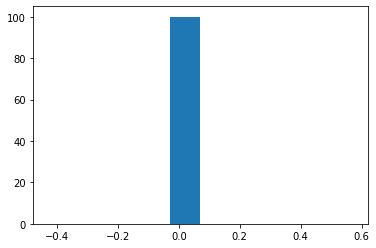

In [ ]:
plt.hist(Hypothesis_Truth['MER']);

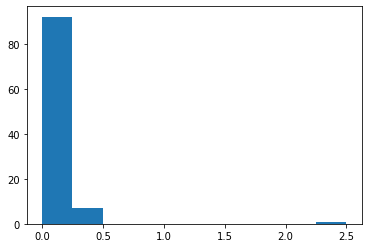

In [ ]:
plt.hist(Hypothesis_Truth['WER']);